<a href="https://colab.research.google.com/github/paperspoon/keras_lstm_time_series/blob/master/keras_lstm_metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/ternaryrealm/lstm-time-series-explorations-with-keras

위 주소의 소스를 참고해서 메트릭 데이터를 예측하는 예제를 만들어봤습니다.

소스는 하나디비에서 메모리의 메트릭 아이디를 하나 뽑아다 썼네요. ( https://jogi.atlassian.net/wiki/spaces/SPA/pages/819275 )

전체 약 28만개의 데이터중에 앞에 10만개만 빼다가 테스트 해봤습니다.

60%는 학습, 20%는 테스트, 20%는 검증에 썼네요.

학습시 epoch가 2되면서 부터 이미 손실이 거의 없는 조작 데이터의 특성이 잘 드러납니다..ㅎ

10만개면 약 3개월치인데 학습이 1분만에 끝나버리네요.

소스도 복붙이라 큰 의미가 없는듯 하지만 일단 해봐서 재밌었네요!


In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

df = pd.read_csv('https://jogi-hckim.s3.ap-northeast-2.amazonaws.com/met_perf_memory.csv',  sep=',', names=['stime', 'metric_val'])

scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(df[:100000]['metric_val'].values.reshape(-1, 1))

TRAIN_SIZE = 0.60
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = int((len(dataset) - train_size) / 2)
validation_size = test_size
train, test, valid = dataset[0:train_size, :], dataset[train_size:train_size + test_size, :], dataset[train_size + test_size:len(dataset), :]
print(f"number of entries train: {len(train)}, test: {len(test)}, valid: {len(valid)}")

number of entries train: 60000, test: 20000, valid: 20000


In [0]:
def create_dataset(dataset, window_size = 1):
  data_x, data_y = [], []
  for i in range(len(dataset) - window_size - 1):
    a = dataset[i:(i+window_size), 0]
    data_x.append(a)
    data_y.append(dataset[i+window_size, 0])
  return(np.array(data_x), np.array(data_y))


window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
valid_X, valid_Y = create_dataset(valid, window_size)
print("Original training data shape:")
print(train_X.shape)

train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
valid_X = np.reshape(valid_X, (valid_X.shape[0], 1, valid_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

print("Test data shape:")
print(test_X.shape)

Original training data shape:
(59998, 1)
New training data shape:
(59998, 1, 1)
Test data shape:
(19998, 1, 1)


In [0]:
def fit_model(train_X, train_Y, test_X, test_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(4, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    
    history = model.fit(train_X, 
              train_Y,
              epochs = 3, 
              batch_size = 10, 
              validation_data=(test_X, test_Y),
              verbose = 1)
    
    return(model, history)

model1, history = fit_model(train_X, train_Y, test_X, test_Y, window_size)

Train on 59998 samples, validate on 19998 samples
Epoch 1/3
59998/59998 [==============================] - 19s 312us/step - loss: 0.0079 - val_loss: 1.4309e-04
Epoch 2/3
59998/59998 [==============================] - 16s 270us/step - loss: 1.5416e-04 - val_loss: 1.5927e-04
Epoch 3/3
59998/59998 [==============================] - 16s 261us/step - loss: 1.5201e-04 - val_loss: 1.4011e-04


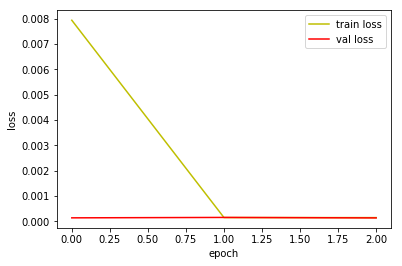

In [0]:
fig, loss_ax = plt.subplots()
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

plt.show()

In [0]:
def predict_and_score(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    orig_data = scaler.inverse_transform([Y])
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)
rsme_validation, validation_predict = predict_and_score(model1, valid_X, valid_Y )

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)
print("Validation data score: %.2f RMSE" % rsme_validation)

Training data score: 0.15 RMSE
Test data score: 0.14 RMSE
Validation data score: 0.15 RMSE


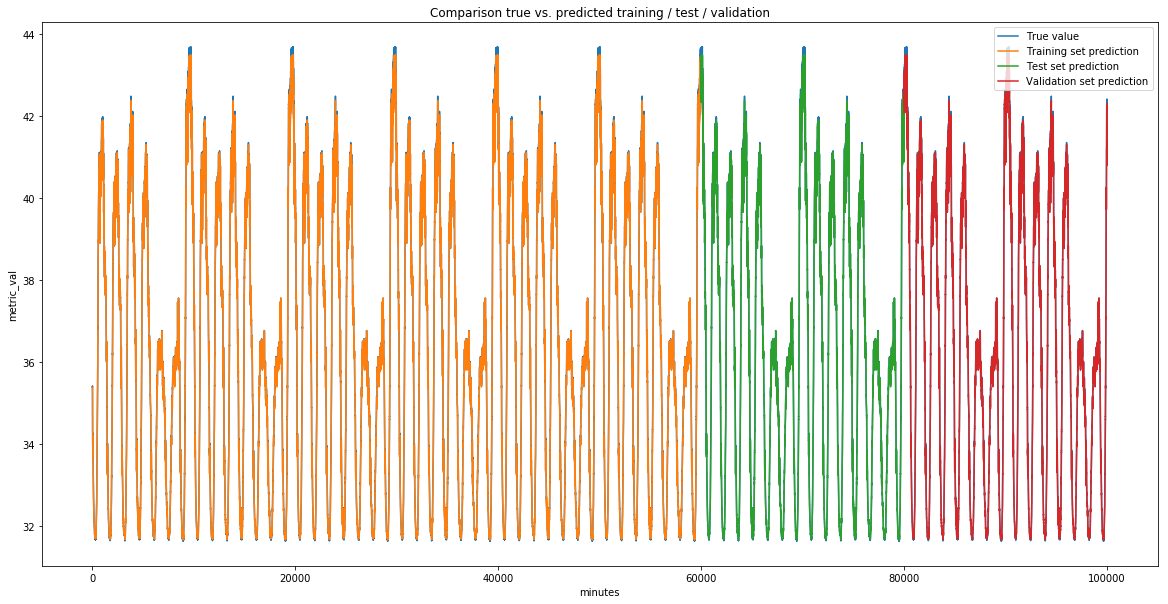

In [0]:
import matplotlib.pyplot as plt

train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - len(test_predict) - 3, :] = test_predict

val_predict_plot = np.empty_like(dataset)
val_predict_plot[:, :] = np.nan
val_predict_plot[len(train_predict) + len(test_predict) + (window_size * 2) + 1:len(dataset) - 3, :] = validation_predict


plt.figure(figsize = (20, 10))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.plot(val_predict_plot, label = "Validation set prediction")
plt.xlabel("minutes")
plt.ylabel("metric_val")
plt.title("Comparison true vs. predicted training / test / validation")
plt.legend()
plt.show()